C:\Users\dell\AppData\Local\Temp\ipykernel_20800\3454424932.py:96: RuntimeWarning: invalid value encountered in divide
  unit_vector = vector / np.linalg.norm(vector)


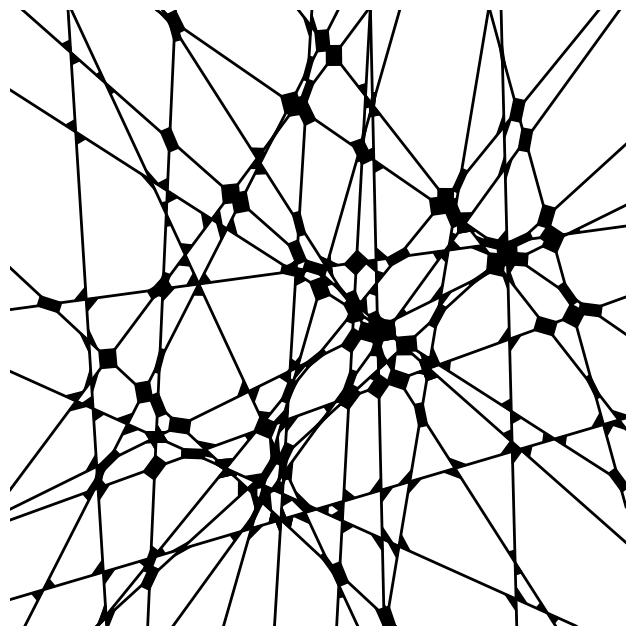

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi
from shapely.geometry import LineString, Point, MultiLineString, box
from shapely.ops import unary_union
from matplotlib.patches import Polygon

def generate_random_points(num_points, size):

    points = np.random.rand(num_points, 2) * size
    return points

def extend_line(line, size):

    p1, p2 = line.coords
    direction = np.array(p2) - np.array(p1)
    unit_direction = direction / np.linalg.norm(direction)

    extended_p1 = np.array(p1) - unit_direction * size * 2
    extended_p2 = np.array(p2) + unit_direction * size * 2

    extended_line = LineString([extended_p1, extended_p2])
    bounding_box = box(0, 0, size, size)
    extended_line = extended_line.intersection(bounding_box)

    return extended_line

def create_voronoi_diagram(points, size, line_width, offset_distance):

    # 创建v图
    vor = Voronoi(points)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_aspect('equal', 'box')
    ax.axis('off')
    
    lines = []

    # 绘制v线
    for simplex in vor.ridge_vertices:
        if -1 in simplex:
            continue
        line = LineString(vor.vertices[simplex])
        extended_line = extend_line(line, size)
        if not extended_line.is_empty:
            lines.append(extended_line)

    merged = unary_union(lines)
    intersection_points = []

    
    if isinstance(merged, (LineString, MultiLineString)):
        for line in merged.geoms if isinstance(merged, MultiLineString) else [merged]:
            for pt in line.coords:
                intersection_points.append(Point(pt))
    else:
        for geom in merged.geoms:
            if isinstance(geom, LineString):
                for pt in geom.coords:
                    intersection_points.append(Point(pt))

    intersection_points = list(set(intersection_points))

    # 绘制线条
    for line in lines:
        if isinstance(line, LineString):
            x, y = line.xy
            ax.plot(x, y, lw=line_width, color='black')

    for point in intersection_points:
        draw_triangle(ax, point, lines, offset_distance)

    plt.show()

def draw_triangle(ax, center, lines, offset_distance):

    cx, cy = center.x, center.y

    connected_points = []
    for line in lines:
        if center.distance(line) < 1e-6:
            for pt in line.coords:
                connected_points.append(pt)

    connected_points = list(set(connected_points))
    
    # 确保点
    if len(connected_points) < 2:
        return

    offsets = []
    for pt in connected_points:
        px, py = pt
        vector = np.array([px - cx, py - cy])
        unit_vector = vector / np.linalg.norm(vector)
        offset_point = (cx + unit_vector[0] * offset_distance, cy + unit_vector[1] * offset_distance)
        offsets.append(offset_point)

    # 三角形
    for i in range(len(offsets)):
        p1 = offsets[i]
        p2 = offsets[(i + 1) % len(offsets)]
        triangle_points = [
            (cx, cy),  
            p1,        
            p2         
        ]
        triangle = Polygon(triangle_points, closed=True, edgecolor='black', facecolor='black')
        ax.add_patch(triangle)

# 参数设置
num_points = 15  # 生成随机点数量
size = 1  # 正方形的尺寸
line_width = 2.0  # 线条宽度
offset_distance = 0.02  # 偏移距离


points = generate_random_points(num_points, size)
create_voronoi_diagram(points, size, line_width, offset_distance)
